# This notebook focuses on the metadata for dyskinesia

In [1]:
#baseDIR = '/home/pataki/synapse/gitParkinson/' # base directory of the github repo
#uncomment the line above (+ update) if you are running this notebook in an empty namespace
try: baseDIR
except NameError:
    print('Error: baseDIR not found!')

In [2]:
cd $baseDIR/sub2.2_dysk/

/home/pataki/synapse/gitParkinson/sub2.2_dysk


In [3]:
%run -i ../src/helperFuncs.py

In [4]:
%matplotlib inline

In [5]:
mainDF = mainDFCreator('dyskinesiaScore')

Train shape: (1556, 12)
Test shape:  (660, 12)
Merged:      (2216, 12)


In [6]:
mainDF.groupby('dyskinesiaScore').count()[['site']].rename(columns={'site':'count'})

,count
dyskinesiaScore,
0.0,1236
1.0,320
Score,660


In [7]:
#returns a heatmap of a pivot table. the two dimensions are the feat1 and feat2. 
#value is the hitRate (#pos/(#pos + #neg))
def featPivot(feat1, feat2, mainDF, vmin, vmax): # vmin, vmax is for the color scale
    tmpDF = mainDF.reset_index(drop=True).reset_index()[['index', feat1, feat2, 'dyskinesiaScore']]
    tmpDF = tmpDF[tmpDF.dyskinesiaScore != 'Score'] # I focus only on 0.0 and 1.0
    tmpDF = tmpDF.groupby([feat1, feat2, 'dyskinesiaScore']).count().reset_index()
    sc1 = tmpDF[tmpDF.dyskinesiaScore == 1.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score1'})
    sc0 = tmpDF[tmpDF.dyskinesiaScore == 0.0][[feat1, feat2, 'index']].rename(columns = {'index': 'score0'})
    tmpDF = pd.merge(sc1, sc0, on = [feat1, feat2], how = 'outer').fillna(0)
    tmpDF['hitRate'] = tmpDF.score1 / (tmpDF.score1 + tmpDF.score0)
    tmpDF = tmpDF.pivot(index = feat1, columns = feat2, values = 'hitRate')

    mask = tmpDF.isnull()
    sns.heatmap(tmpDF, mask = mask, 
                cmap = sns.dark_palette("muted purple", input="xkcd"), vmin = vmin, vmax = vmax)
    plt.show()

## Check the meta features if they contain useful information

In [8]:
mainDF.groupby(['site', 'dyskinesiaScore']).count()[['session']].rename(columns={'session':'count'})
# focus only for Boston

count
site   dyskinesiaScore       
Boston 0.0                741
       1.0                315
       Score              480
NYC    0.0                495
       1.0                  5
       Score              180

['device', 'patient', 'session', 'site', 'task', 'visit', 'deviceSide']


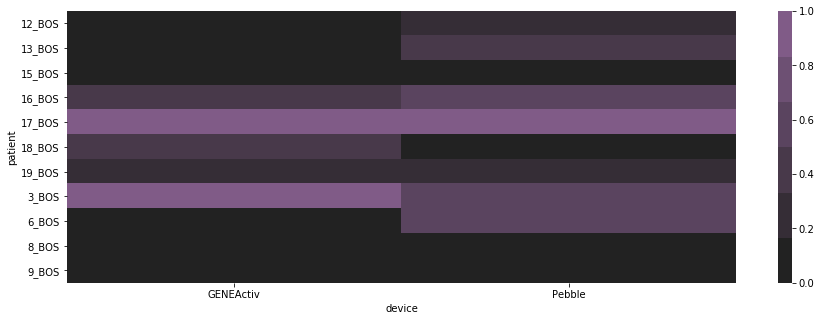

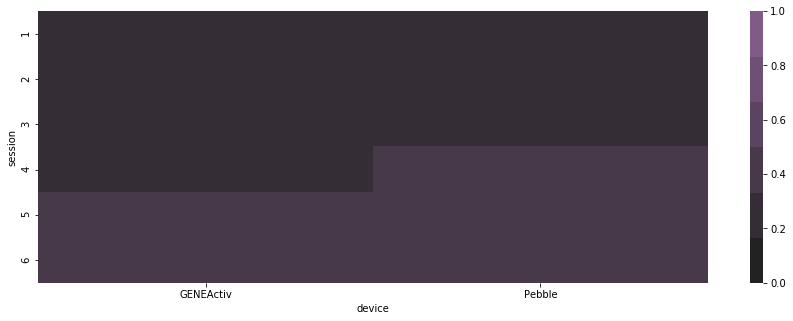

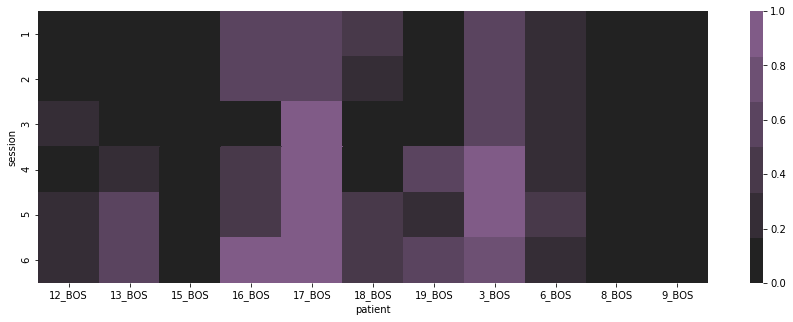

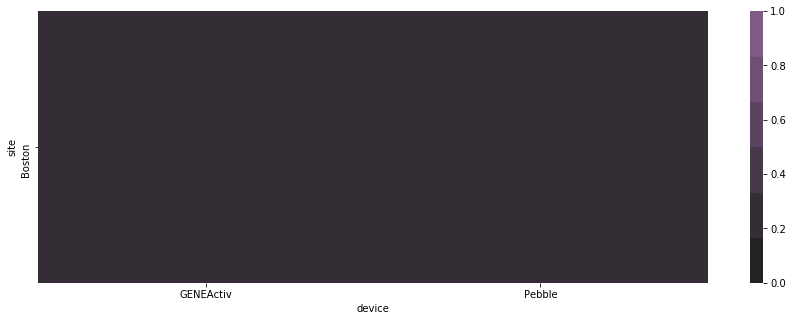

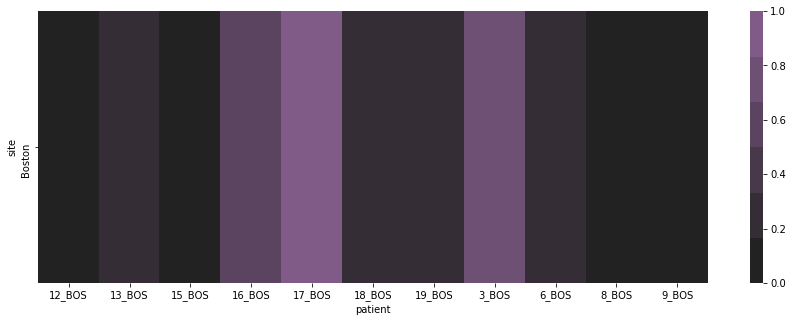

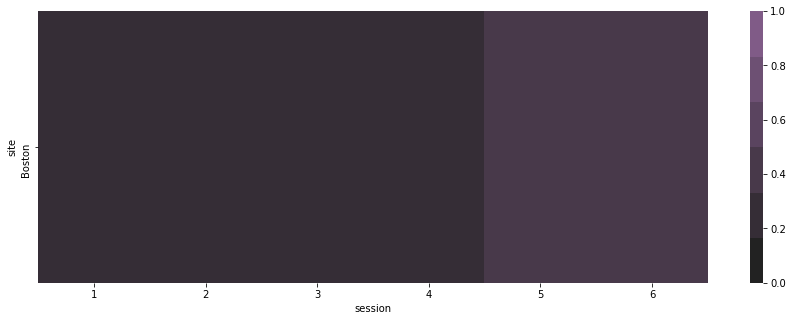

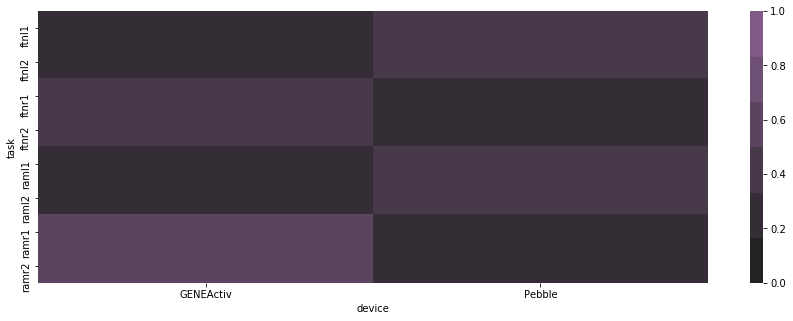

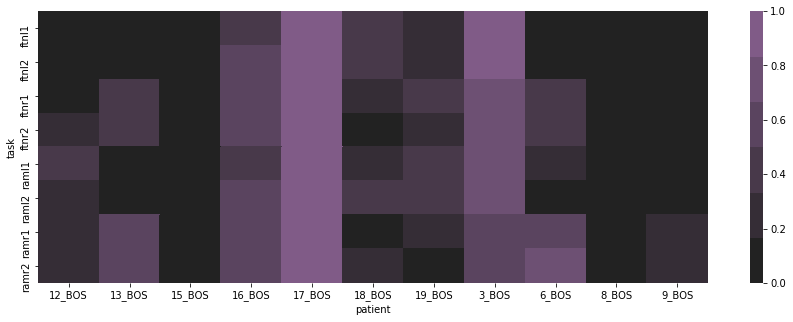

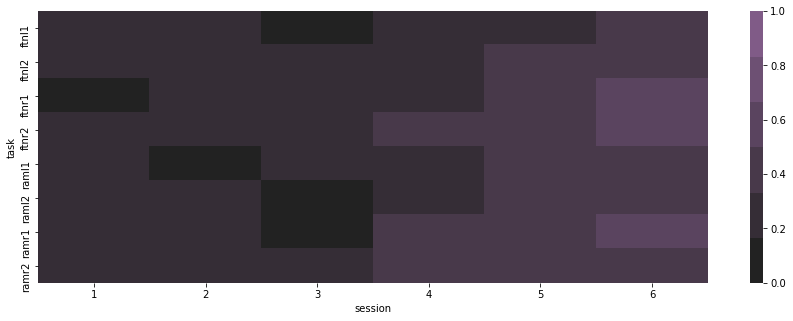

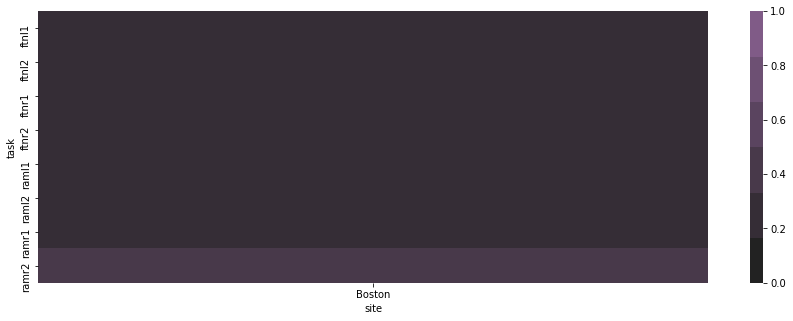

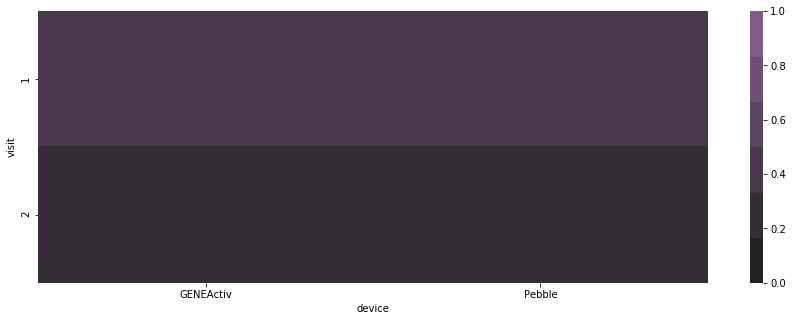

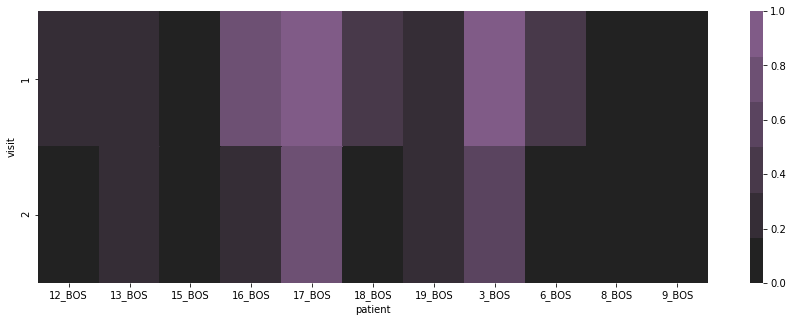

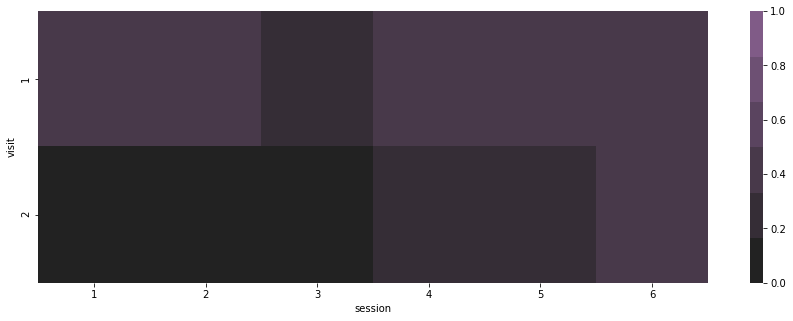

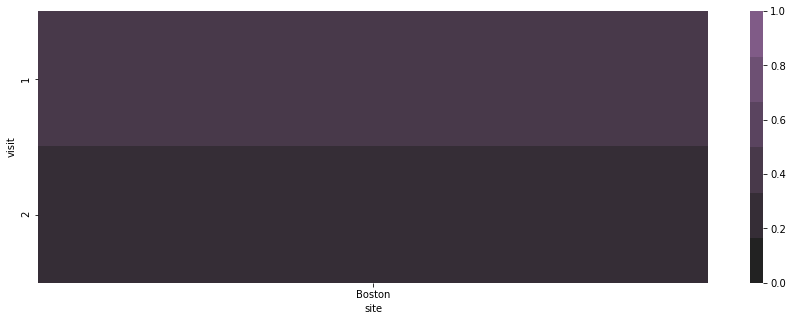

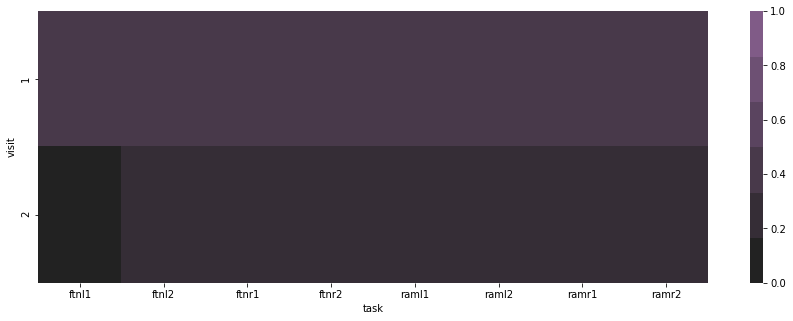

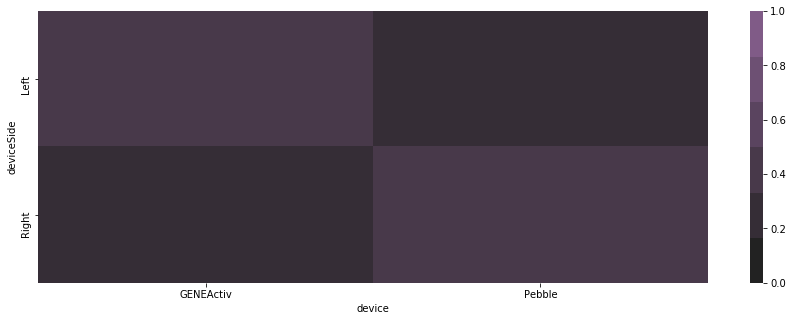

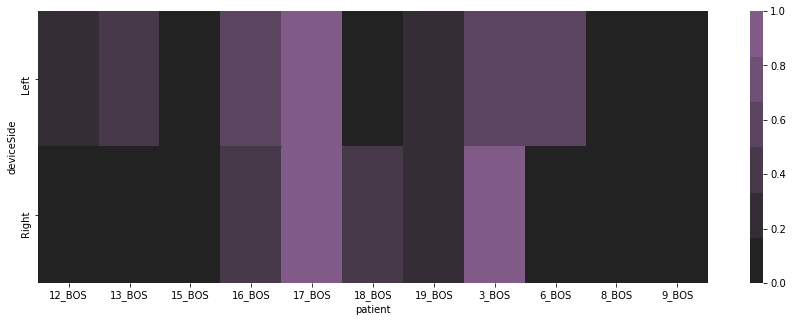

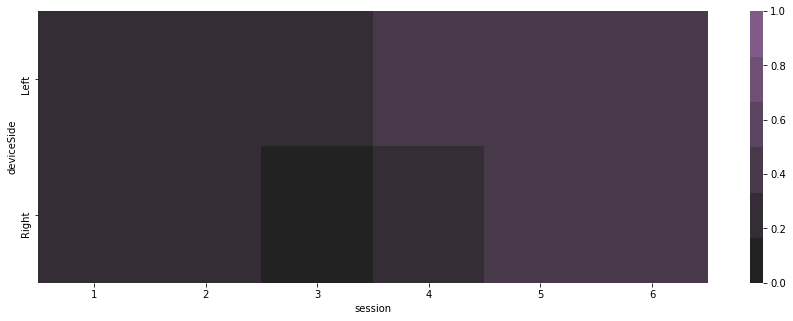

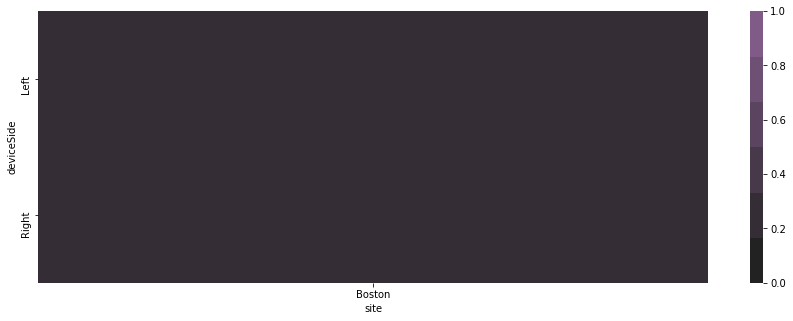

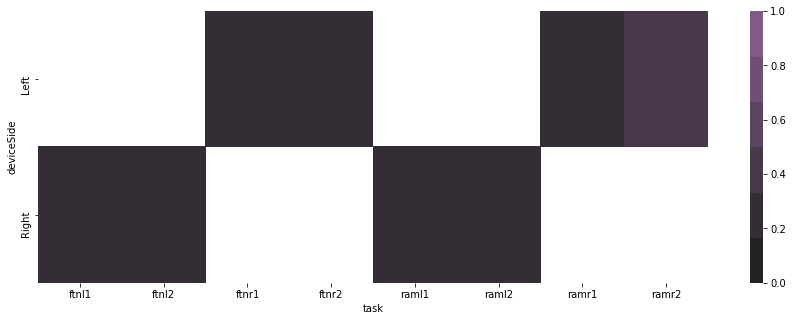

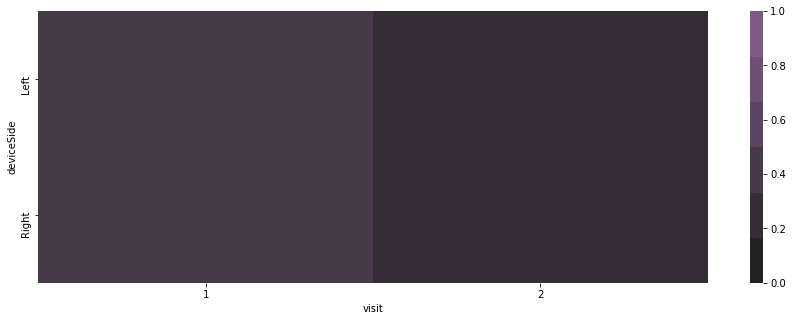

In [9]:
plt.rcParams['figure.figsize']=(15,5)

features = mainDF.columns.tolist()[2:-1]
print(features)
for i in range(len(features)):
    for j in range(len(features)):
        if(i > j):
            plt.subplot()
            subPlot = featPivot(features[i], features[j], mainDF[mainDF.site == 'Boston'], 0.0, 1.0)

In [10]:
mainDF[mainDF.site == 'Boston'].groupby(['visit', 
                                         'dyskinesiaScore']).count()[['site']].rename(columns={'site':'count'})

count
visit dyskinesiaScore       
1     0.0                320
      1.0                208
      Score              240
2     0.0                421
      1.0                107
      Score              240

In [11]:
mainDF[mainDF.site == 'Boston'].groupby(['session', 
                                         'dyskinesiaScore']).count()[['site']].rename(columns={'site':'count'})

count
session dyskinesiaScore       
1       0.0                138
        1.0                 38
        Score               80
2       0.0                138
        1.0                 38
        Score               80
3       0.0                141
        1.0                 35
        Score               80
4       0.0                118
        1.0                 58
        Score               80
5       0.0                108
        1.0                 68
        Score               80
6       0.0                 98
        1.0                 78
        Score               80

In [13]:
nonTrivial = mainDF
count0 = nonTrivial[(nonTrivial.dyskinesiaScore == 0.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.dyskinesiaScore == 1.0) & (nonTrivial.site == 'Boston')].groupby('session').count()[['site']].rename(columns={'site':'BOS1count'}).reset_index()

BOSsessDF = pd.merge(count0, count1, on='session', how='outer').fillna(0)
BOSsessDF['BOShitRate'] = BOSsessDF['BOS1count']/(BOSsessDF['BOS0count'] + BOSsessDF['BOS1count'])

count0 = nonTrivial[(nonTrivial.dyskinesiaScore == 0.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC0count'}).reset_index()
count1 = nonTrivial[(nonTrivial.dyskinesiaScore == 1.0) & (nonTrivial.site == 'NYC')].groupby('session').count()[['site']].rename(columns={'site':'NYC1count'}).reset_index()

NYCsessDF = pd.merge(count0, count1, on='session', how='outer').fillna(0)
NYCsessDF['NYChitRate'] = NYCsessDF['NYC1count']/(NYCsessDF['NYC0count'] + NYCsessDF['NYC1count'])

pd.merge(NYCsessDF, BOSsessDF, on ='session', how='outer')

,session,NYC0count,NYC1count,NYChitRate,BOS0count,BOS1count,BOShitRate
0,1,64,0.0,0.000000,138.0,38.0,0.215909
1,2,64,0.0,0.000000,138.0,38.0,0.215909
2,3,62,2.0,0.031250,141.0,35.0,0.198864
3,4,63,1.0,0.015625,118.0,58.0,0.329545
4,5,63,1.0,0.015625,108.0,68.0,0.386364
5,6,63,1.0,0.015625,98.0,78.0,0.443182
6,7,60,0.0,0.000000,NaN,NaN,NaN
7,8,56,0.0,0.000000,NaN,NaN,NaN


## feature1: 1 if bos+visit1, 0.5 if bos+visit2 else 0.0
## feature2: session/5 if bos else 0

In [14]:
mainDF['isBos'] = mainDF.site == 'Boston'

In [15]:
mainDF['empirical2'] = mainDF.isBos * mainDF.session / 5.0
mainDF['empirical1'] = mainDF.isBos * (1/mainDF.visit)

In [16]:
mainDF[['dataFileHandleId', 'empirical1', 
        'empirical2']].to_csv('featureDB/empiricalFeature.tsv', sep = '\t', index=False)

In [17]:
baseFeatureDF = mainDFCreator('dyskinesiaScore')

Train shape: (1556, 12)
Test shape:  (660, 12)
Merged:      (2216, 12)


#### binarizing metafeatures except for the session and visit

In [18]:
baseFeatureDF = featureBinarizer(baseFeatureDF, ['device', 'site', 'task', 'deviceSide'])
baseFeatureDF.head()

device ['GENEActiv' 'Pebble']
site ['Boston' 'NYC']
task ['ftnl1' 'ftnl2' 'ftnr1' 'ftnr2' 'raml1' 'raml2' 'ramr1' 'ramr2']
deviceSide ['Right' 'Left']


,dataFileHandleId,fileName,patient,session,visit,dyskinesiaScore,device_1,site_1,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,deviceSide_1
4,17286039,/home/pataki/.synapseCache/39/17286039/ftnl1_G...,13_BOS,1,1,0,0,0,1,0,0,0,0,0,0,0,1
6,17286045,/home/pataki/.synapseCache/45/17286045/ftnl2_G...,13_BOS,1,1,0,0,0,0,1,0,0,0,0,0,0,1
9,17286054,/home/pataki/.synapseCache/54/17286054/ftnr1_P...,13_BOS,1,1,0,1,0,0,0,1,0,0,0,0,0,0
11,17286060,/home/pataki/.synapseCache/60/17286060/ftnr2_P...,13_BOS,1,1,0,1,0,0,0,0,1,0,0,0,0,0
16,17286076,/home/pataki/.synapseCache/76/17286076/raml1_G...,13_BOS,1,1,0,0,0,0,0,0,0,1,0,0,0,1


In [19]:
baseFeatureDF.pop('patient');
baseFeatureDF.pop('fileName');
baseFeatureDF.pop('dyskinesiaScore');

In [20]:
baseFeatureDF.to_csv('featureDB/baseFeatures.tsv', sep = '\t', index=False)